In [1]:
# Installing 
!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install transformers --quiet
!pip install -q sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 63.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text


from transformers import T5Tokenizer, TFT5Model, TFT5ForConditionalGeneration, TFT5EncoderModel

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import transformers

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim

In [3]:
#@title Plotting Function

# 2-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history,  
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower = np.min(model_history.history[metric]) * 0.9

        y_lim_upper = np.max(model_history.history[metric]) * 1.1

        ax1 = axs[i]
        ax1.plot(model_history.history[metric])
        ax1.plot(model_history.history['val_%s' % metric])
        ax1.set_ylabel(metric, bbox=box)
        ax1.set_ylim(y_lim_lower, y_lim_upper)

In [4]:
import pandas as pd
# Load the LIAR-PLUS dataset
from google.colab import files
uploaded = files.upload()


Saving final_liar_features.csv to final_liar_features.csv


In [5]:
import io
liar_plus_dataset = pd.read_csv(io.BytesIO(uploaded['final_liar_features.csv']))
# Dataset is now stored in a Pandas Datafram

In [6]:
# Remove punctuation (so as not to confuse t5) and check unique labels
liar_plus_dataset['label'] = liar_plus_dataset['label'].apply(lambda x: x.replace('-', ' '))
liar_plus_dataset['label'].unique()

array(['false', 'half true', 'mostly true', 'true', 'barely true',
       'pants fire'], dtype=object)

In [7]:
liar_plus_dataset['label_num'].unique()

array([1, 3, 4, 5, 2, 0])

In [8]:
# Confirm that the label nums are assigned correctly and check the distribution
liar_plus_dataset.groupby(['label_num', 'label']).size()

label_num  label      
0          pants fire     1050
1          false          2511
2          barely true    2108
3          half true      2638
4          mostly true    2466
5          true           2063
dtype: int64

In [9]:
# Create a binary label (should be text for t5) and confirm this was done correctly
liar_plus_dataset['binary_label'] = np.where(liar_plus_dataset['binary_label_num'] == 1, 'false', 'true')
liar_plus_dataset.groupby(['binary_label', 'label']).size()

binary_label  label      
false         barely true    2108
              false          2511
              pants fire     1050
true          half true      2638
              mostly true    2466
              true           2063
dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

# Load the LIAR Plus dataset from a CSV file
df = liar_plus_dataset

Data Preparation

In [11]:
# Pre-processing steps of the input claim for T5 classification task

def prep_for_t5(input_claim):
  # pre-pend the data with the task: since we're not using one of T5's built in tasks we can just make up our own
  input_claim = 'truthfulness: ' + input_claim
  # also need to add the closing token
  input_claim = input_claim + '</s.'
  return input_claim


# Apply to the dataset

# Claim is the original claim on its own
df['claim'] = df['claim'].apply(prep_for_t5)

# Combined text is the claim + concatenated metadata
df['combined_text'] = df['combined_text'].apply(prep_for_t5)
df


,id,label,label_num,binary_label_num,ternary_label_num,claim,combined_text,fear,anger,anticipation,...,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji,combined_pos,binary_label
0,0,false,1,1,2,truthfulness: Says the Annies List political g...,truthfulness: Says the Annies List political g...,0.166667,0.166667,0.000000,...,18.75,6.25,0.00,0.00,0.0,0.00,12.50,0,Says the Annies List political group supports ...,false
1,1,half true,3,0,1,truthfulness: When did the decline of coal sta...,truthfulness: When did the decline of coal sta...,0.000000,0.000000,0.250000,...,22.58,6.45,0.00,3.23,0.0,0.00,12.90,0,When did the decline of coal start? It started...,true
2,2,mostly true,4,0,0,"truthfulness: ""Hillary Clinton agrees with Joh...","truthfulness: ""Hillary Clinton agrees with Joh...",0.200000,0.000000,0.000000,...,39.13,4.35,0.00,0.00,0.0,0.00,34.78,0,"""Hillary Clinton agrees with John McCain """"by ...",true
3,3,false,1,1,2,truthfulness: Health care reform legislation i...,truthfulness: Health care reform legislation i...,0.166667,0.000000,0.166667,...,21.43,7.14,0.00,0.00,0.0,0.00,14.29,0,Health care reform legislation is likely to ma...,false
4,4,half true,3,0,1,truthfulness: The economic turnaround started ...,truthfulness: The economic turnaround started ...,0.000000,0.000000,0.000000,...,14.29,7.14,0.00,0.00,0.0,0.00,7.14,0,The economic turnaround started at the end of ...,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12831,1279,half true,3,0,1,truthfulness: For the first time in more than ...,truthfulness: For the first time in more than ...,0.000000,0.000000,0.500000,...,23.08,3.85,3.85,0.00,0.0,0.00,15.38,0,"For the first time in more than a decade, impo...",true
12832,1280,mostly true,4,0,0,truthfulness: Says Donald Trump has bankrupted...,truthfulness: Says Donald Trump has bankrupted...,0.000000,0.000000,0.000000,...,20.00,5.00,5.00,0.00,0.0,0.00,10.00,0,Says Donald Trump has bankrupted his companies...,true
12833,1281,true,5,0,0,"truthfulness: ""John McCain and George Bush hav...","truthfulness: ""John McCain and George Bush hav...",0.000000,0.000000,1.000000,...,72.22,16.67,5.56,0.00,0.0,0.00,50.00,0,"""John McCain and George Bush have """"absolutely...",true
12834,1282,false,1,1,2,truthfulness: A new poll shows 62 percent supp...,truthfulness: A new poll shows 62 percent supp...,0.000000,0.000000,0.375000,...,26.47,14.71,0.00,0.00,0.0,2.94,8.82,0,A new poll shows 62 percent support the presid...,false


In [12]:
# Will need to tokenize the labels for T5 as well - check the lengths so we can pad appropriately
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [13]:
# What is the max length of any of our tokenizers?
t5_tokenizer(list(df['label'].unique()))
# Looks like it's 3

{'input_ids': [[6136, 1], [985, 1176, 1], [3323, 1176, 1], [1176, 1], [11289, 1176, 1], [12792, 1472, 1]], 'attention_mask': [[1, 1], [1, 1, 1], [1, 1, 1], [1, 1], [1, 1, 1], [1, 1, 1]]}

In [14]:
# What about binary?
t5_tokenizer(list(df['binary_label'].unique()))
# Looks like it's 2

{'input_ids': [[6136, 1], [1176, 1]], 'attention_mask': [[1, 1], [1, 1]]}

In [15]:
train, val, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

In [16]:
# Convert to dictionary for easier processing into tensorflow dataset
train = train.to_dict('records')
val = val.to_dict('records')
test = test.to_dict('records')

In [17]:
TFT5EncoderModel._keys_to_ignore_on_load_unexpected = ["decoder.*"]
T5_encoder_model = TFT5EncoderModel.from_pretrained("t5-small")

All model checkpoint layers were used when initializing TFT5EncoderModel.

All the layers of TFT5EncoderModel were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5EncoderModel for predictions without further training.


# Adding EmoLex + LIWC


In [18]:
def create_t5_emo_LIWC_model(num_classes = 6,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00005):

    activation_fn = 'softmax'
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
   
    # concatenated claim input
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='attention_mask_layer')

    # Define an additional input layer for the EmoLex features
    emoLex_input = tf.keras.Input(shape=(10,), name='emoLex_features')

    # # Define an additional input layer for the LIWC features
    LIWC_input = tf.keras.Input(shape=(119,), name='LIWC_features')

    t5_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}      

    t5_out = T5_encoder_model(t5_inputs).last_hidden_state

    # Our own equivalent of the BERT cls token
    cls_token = tf.keras.layers.GlobalAveragePooling1D()(t5_out)

    concatenated_output = tf.concat([cls_token, emoLex_input, LIWC_input], axis=-1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(concatenated_output)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
   
    classification = tf.keras.layers.Dense(num_classes, activation=activation_fn,name='classification_layer')(hidden)
   
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask, emoLex_input, LIWC_input], outputs=[classification])
   
   
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=loss_fn,
                                 metrics='accuracy')

    return classification_model

In [19]:
six_way_emo_LIWC_model = create_t5_emo_LIWC_model(num_classes=6, learning_rate=0.0001)

In [20]:
# Get the tokenized text for T5 - we're using the concatenated input data for this
test_input = [x['combined_text'] for x in test]
train_input = [x['combined_text'] for x in train]
val_input = [x['combined_text'] for x in val]

def tokenize_list(my_list):
  tokenized = [t5_tokenizer(x, padding='max_length', max_length=512, truncation=True, return_tensors='tf') for x in my_list]
  input_ids = np.array([x['input_ids'][0] for x in tokenized])
  attention_mask = np.array([x['attention_mask'][0] for x in tokenized])
  return input_ids, attention_mask

test_input_ids, test_attention_mask = tokenize_list(test_input)
train_input_ids, train_attention_mask = tokenize_list(train_input)
val_input_ids, val_attention_mask = tokenize_list(val_input)

test_labels = np.array([x['label_num'] for x in test])
train_labels = np.array([x['label_num'] for x in train])
val_labels =np.array([x['label_num'] for x in val])

test_labels_binary = np.array([x['binary_label_num'] for x in test])
train_labels_binary = np.array([x['binary_label_num'] for x in train])
val_labels_binary = np.array([x['binary_label_num'] for x in val])

In [21]:
test_labels

array([2, 3, 1, ..., 1, 1, 3])

In [22]:
# Create a list of the additional features
emolex_cols = []
LIWC_cols = []
for col_num, col in enumerate(train[0].keys()):
  if col_num > 6 and col_num < 17:
    emolex_cols.append(col)
  elif col_num >= 17 and col_num < 136:
    LIWC_cols.append(col)

# Create a list to input into the model - emolex
test_emolex = np.array([[x[col] for col in emolex_cols] for x in test])
train_emolex = np.array([[x[col] for col in emolex_cols] for x in train])
val_emolex = np.array([[x[col] for col in emolex_cols] for x in val])


# Create a list to input into the model - liwc
test_liwc = np.array([[x[col] for col in LIWC_cols] for x in test])
train_liwc = np.array([[x[col] for col in LIWC_cols] for x in train])
val_liwc = np.array([[x[col] for col in LIWC_cols] for x in val])

In [23]:
# Fit the model- six way
six_way_emo_LIWC_history = six_way_emo_LIWC_model.fit([train_input_ids, train_attention_mask, train_emolex, train_liwc], 
    train_labels,   
    validation_data=(
        [val_input_ids, val_attention_mask, val_emolex, val_liwc],  
        val_labels
    ),    
    batch_size=24, 
    epochs=10)


Epoch 1/10
321/321 [==============================] - 42s 111ms/step - loss: 6.1213 - accuracy: 0.1754 - val_loss: 2.4347 - val_accuracy: 0.1905
Epoch 2/10
321/321 [==============================] - 34s 106ms/step - loss: 3.1986 - accuracy: 0.1878 - val_loss: 2.0216 - val_accuracy: 0.1959
Epoch 3/10
321/321 [==============================] - 34s 106ms/step - loss: 2.1694 - accuracy: 0.2004 - val_loss: 1.8621 - val_accuracy: 0.1913
Epoch 4/10
321/321 [==============================] - 34s 106ms/step - loss: 1.9013 - accuracy: 0.2040 - val_loss: 1.8153 - val_accuracy: 0.1948
Epoch 5/10
321/321 [==============================] - 34s 106ms/step - loss: 1.8382 - accuracy: 0.2026 - val_loss: 1.7967 - val_accuracy: 0.2010
Epoch 6/10
321/321 [==============================] - 34s 106ms/step - loss: 1.7926 - accuracy: 0.2123 - val_loss: 1.7873 - val_accuracy: 0.2030
Epoch 7/10
321/321 [==============================] - 34s 106ms/step - loss: 1.7747 - accuracy: 0.2211 - val_loss: 1.7814 - val_ac

In [24]:
#Create mapping from numeric labels to text labels (different for six way vs. binary)
label_map = {'six classes': ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true'], 'binary': ['true', 'false']}

In [25]:
# Function to evaluate a model and proudce metrics for the report, as well as some preliminary analysis

# helpful source: https://stackoverflow.com/questions/32576914/random-sample-of-paired-lists-in-python
from sklearn.metrics import classification_report, f1_score
from random import sample
import seaborn as sns
def  evaluate_model(model, model_history, other_inputs, train_labels, test_labels, test_input_ids, train_input_ids, **kwargs):
  # Display the learning curve to check for over fitting
  print("Learning Curve")
  fig, axs = plt.subplots(1,2)
  fig.subplots_adjust(left=0.2, wspace=0.6)
  make_plot(axs,
              model_history,
              )

  fig.set_size_inches(12.5,5.5)
  plt.show()

  # Calculate the test predictions
  predictions = model.predict([test_input_ids, test_attention_mask]+other_inputs)
  
  
  predictions = tf.argmax(predictions, axis=1)
  predictions = predictions.numpy()

  # F1 score table
  print("Precision, Recall, F1 Scores by class")
  if len(np.unique(train_labels)) == 6:
    target_names = label_map['six classes']
  else:
    target_names = label_map['binary']
    
  print(classification_report(test_labels, predictions, target_names=target_names))

  # Display the confusion matrix to see which classes are getting mis-classified
  print('Confusion matrix')
  cm = tf.math.confusion_matrix(test_labels, predictions)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(10, 3.5))
  sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  # What class has the lowest F1 score? Print some examples of this class that are getting mis-classified
  f1_by_class = list(f1_score(y_true = test_labels, y_pred = predictions, average=None))
  min_f1 = min(f1_by_class)
  for i, f1 in enumerate(f1_by_class):
    if f1 == min_f1:
      class_label = target_names[i]
      print("Class(es) with lowest f1 score: {}".format(class_label))
      print("Example concatenated statements that are getting misclassified:")
      example_pool = test_input_ids[test_labels != predictions]
      example_pool_labels = test_labels[test_labels != predictions]
      examples = sample(list(zip(example_pool, example_pool_labels)), 3)
      for ex in examples:
        print("Example:", t5_tokenizer.decode(ex[0]))
        print("Predicted label:", target_names[ex[1]])

          

  

Learning Curve


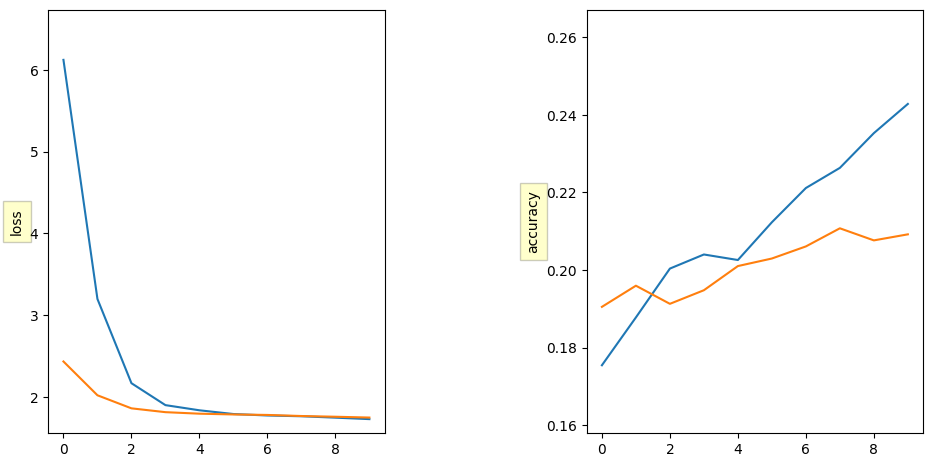

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.07      0.00      0.01       211
       false       0.23      0.23      0.23       523
 barely-true       0.21      0.17      0.19       429
   half-true       0.23      0.29      0.26       534
 mostly-true       0.25      0.41      0.31       469
        true       0.19      0.13      0.15       402

    accuracy                           0.23      2568
   macro avg       0.20      0.20      0.19      2568
weighted avg       0.21      0.23      0.21      2568

Confusion matrix


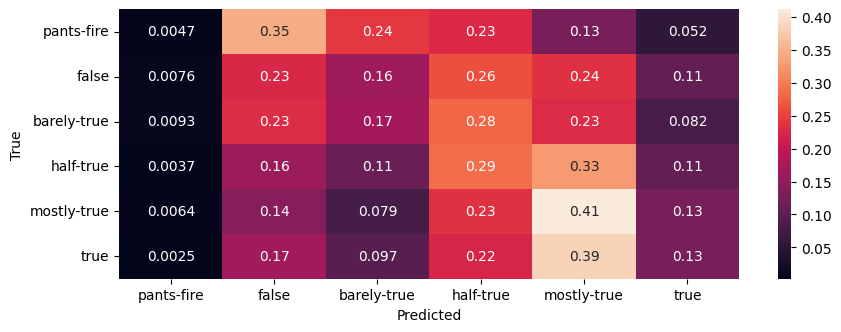

Class(es) with lowest f1 score: pants-fire
Example concatenated statements that are getting misclassified:
Example: truthfulness: Dave Brat worked on Democrat Gov. Tim Kaines Council of Economic Advisors while Kaine tried to raise our taxes by over $1 billion. candidates-biography economy state-budget taxes eric-cantor House Majority Leader Virginia<unk> /s.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [26]:
evaluate_model(six_way_emo_LIWC_model, six_way_emo_LIWC_history, [test_emolex, test_liwc], train_labels, test_labels, test_input_ids, train_input_ids, test_emolex=test_emolex, test_liwc=test_liwc)



# T5: Encoder only for comparison

In [27]:
# This stack overflow post helped with this model: https://stackoverflow.com/questions/71788825/using-the-encoder-part-only-from-t5-
# This discussion also helped with conceptualizing how to replicate the BERT CLS token using T5: https://discuss.huggingface.co/t/significance-of-the-cls-token/3180

# Creating the T5 encoder only model to see if emolex/LIWC adds anything on top of this
def create_t5_encoder_only_model(num_classes = 6,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):

    activation_fn = 'softmax'
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    # concatenated claim input
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='attention_mask_layer')

    t5_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}      

    t5_out = T5_encoder_model(t5_inputs).last_hidden_state

    # Our own equivalent of the BERT cls token
    cls_token = tf.keras.layers.GlobalAveragePooling1D()(t5_out)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation=activation_fn,name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=loss_fn, 
                                 metrics='accuracy')

    return classification_model

In [28]:
six_way_encoder_only_model = create_t5_encoder_only_model(num_classes=6, learning_rate=0.0001)

In [29]:
# Fit the model- six way
six_way_encoder_only_history = six_way_encoder_only_model.fit([train_input_ids, train_attention_mask], 
    train_labels,   
    validation_data=(
        [val_input_ids, val_attention_mask],  
        val_labels
    ),    
    batch_size=24, 
    epochs=10)

Epoch 1/10
321/321 [==============================] - 41s 110ms/step - loss: 1.7135 - accuracy: 0.2295 - val_loss: 1.6961 - val_accuracy: 0.2559
Epoch 2/10
321/321 [==============================] - 34s 106ms/step - loss: 1.6684 - accuracy: 0.2627 - val_loss: 1.6974 - val_accuracy: 0.2587
Epoch 3/10
321/321 [==============================] - 34s 106ms/step - loss: 1.6434 - accuracy: 0.2759 - val_loss: 1.6999 - val_accuracy: 0.2591
Epoch 4/10
321/321 [==============================] - 34s 106ms/step - loss: 1.6031 - accuracy: 0.3005 - val_loss: 1.7296 - val_accuracy: 0.2571
Epoch 5/10
321/321 [==============================] - 34s 106ms/step - loss: 1.5672 - accuracy: 0.3248 - val_loss: 1.7437 - val_accuracy: 0.2563
Epoch 6/10
321/321 [==============================] - 34s 106ms/step - loss: 1.5217 - accuracy: 0.3471 - val_loss: 1.7950 - val_accuracy: 0.2606
Epoch 7/10
321/321 [==============================] - 34s 106ms/step - loss: 1.4648 - accuracy: 0.3761 - val_loss: 1.8292 - val_ac

Learning Curve


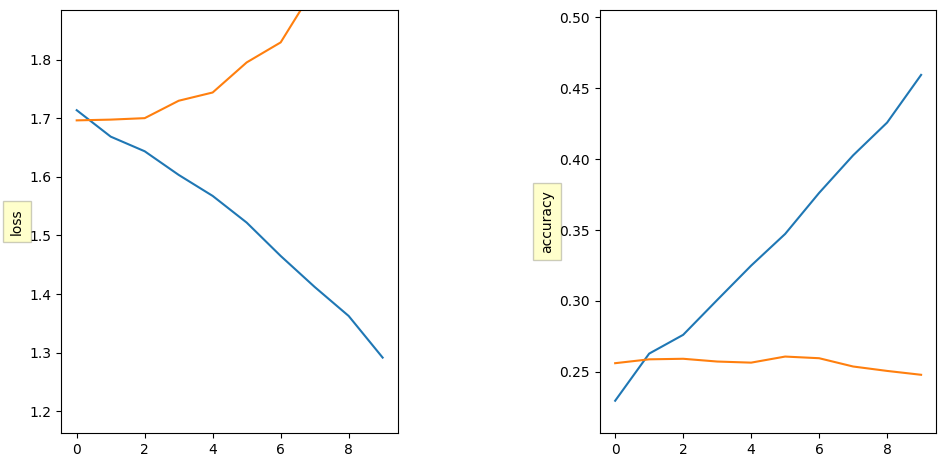

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.35      0.42      0.38       211
       false       0.31      0.24      0.27       523
 barely-true       0.23      0.23      0.23       429
   half-true       0.26      0.30      0.28       534
 mostly-true       0.26      0.25      0.26       469
        true       0.24      0.25      0.25       402

    accuracy                           0.27      2568
   macro avg       0.28      0.28      0.28      2568
weighted avg       0.27      0.27      0.27      2568

Confusion matrix


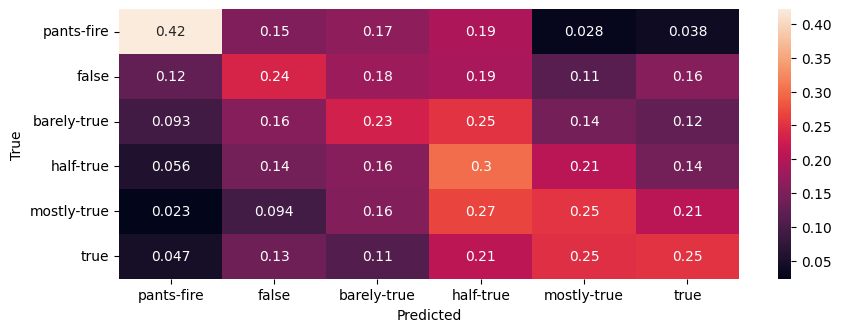

Class(es) with lowest f1 score: barely-true
Example concatenated statements that are getting misclassified:
Example: truthfulness: Pentagon confirms they may court martial soldiers who hold Christian faith. military religion blog-posting <unk> /s.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [31]:
# Creating the T5 encoder only model to see if emolex/LIWC adds anything on top of this
evaluate_model(six_way_encoder_only_model, six_way_encoder_only_history, [], train_labels, test_labels, test_input_ids, train_input_ids)

# Using a subset of the LIWC/EmoLex emotion-based features for further analysis

In [44]:
# This stack overflow post helped with this model: https://stackoverflow.com/questions/71788825/using-the-encoder-part-only-from-t5-
# This discussion also helped with conceptualizing how to replicate the BERT CLS token using T5: https://discuss.huggingface.co/t/significance-of-the-cls-token/3180

# Creating a version of the model that uses T5 + a subset of the features that we've identified from previous models
def create_t5_col_subset(input_size, num_classes = 6,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):                               

    activation_fn = 'softmax'
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    

    # concatenated claim input
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='attention_mask_layer')

    # # Define an additional input layer for the LIWC features
    other_input = tf.keras.Input(shape=(input_size,), name='other_features')

    t5_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}      

    t5_out = T5_encoder_model(t5_inputs).last_hidden_state

    # Our own equivalent of the BERT cls token
    cls_token = tf.keras.layers.GlobalAveragePooling1D()(t5_out)

    # Concatenate
    concatenated_output = tf.concat([cls_token, other_input], axis=-1)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(concatenated_output)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation=activation_fn,name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask, other_input], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=loss_fn, 
                                 metrics='accuracy')

    return classification_model

In [51]:
# Create a list to input into the model - all extreme emotions
extreme_cols=['fear', 'anger', 'anticipation', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy', 'power', 'emo_pos', 'emo_neg', 'emo_anx', 'emo_anger', 'emo_sad']

test_extreme = np.array([[x[col] for col in extreme_cols] for x in test])
train_extreme = np.array([[x[col] for col in extreme_cols] for x in train])
val_extreme = np.array([[x[col] for col in extreme_cols] for x in val])

In [52]:
t5_extreme_model = create_t5_col_subset(input_size=len(extreme_cols))

In [53]:
# Fit the model- six way
t5_extreme_model_history = t5_extreme_model.fit([train_input_ids, train_attention_mask, train_extreme], 
    train_labels,   
    validation_data=(
        [val_input_ids, val_attention_mask, val_extreme],  
        val_labels
    ),    
    batch_size=24, 
    epochs=10)

Epoch 1/10
321/321 [==============================] - 41s 110ms/step - loss: 1.2297 - accuracy: 0.5311 - val_loss: 2.2724 - val_accuracy: 0.2493
Epoch 2/10
321/321 [==============================] - 34s 106ms/step - loss: 0.8258 - accuracy: 0.6819 - val_loss: 2.7527 - val_accuracy: 0.2583
Epoch 3/10
321/321 [==============================] - 34s 106ms/step - loss: 0.6957 - accuracy: 0.7359 - val_loss: 3.0848 - val_accuracy: 0.2446
Epoch 4/10
321/321 [==============================] - 34s 106ms/step - loss: 0.6422 - accuracy: 0.7563 - val_loss: 3.3290 - val_accuracy: 0.2423
Epoch 5/10
321/321 [==============================] - 34s 106ms/step - loss: 0.6008 - accuracy: 0.7720 - val_loss: 3.5299 - val_accuracy: 0.2470
Epoch 6/10
321/321 [==============================] - 34s 106ms/step - loss: 0.5585 - accuracy: 0.7800 - val_loss: 3.6077 - val_accuracy: 0.2462
Epoch 7/10
321/321 [==============================] - 34s 106ms/step - loss: 0.5249 - accuracy: 0.7998 - val_loss: 3.7783 - val_ac

Learning Curve


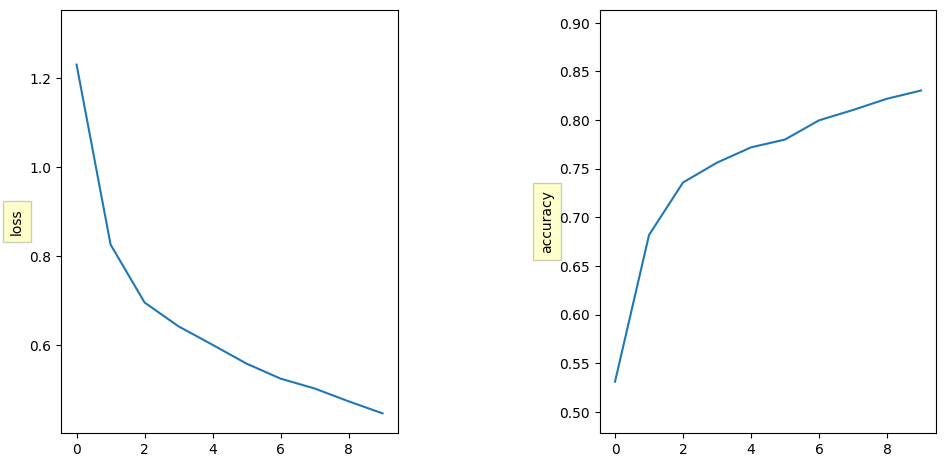

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.36      0.29      0.32       211
       false       0.29      0.21      0.24       523
 barely-true       0.21      0.18      0.19       429
   half-true       0.24      0.29      0.26       534
 mostly-true       0.25      0.35      0.29       469
        true       0.27      0.22      0.24       402

    accuracy                           0.26      2568
   macro avg       0.27      0.26      0.26      2568
weighted avg       0.26      0.26      0.25      2568

Confusion matrix


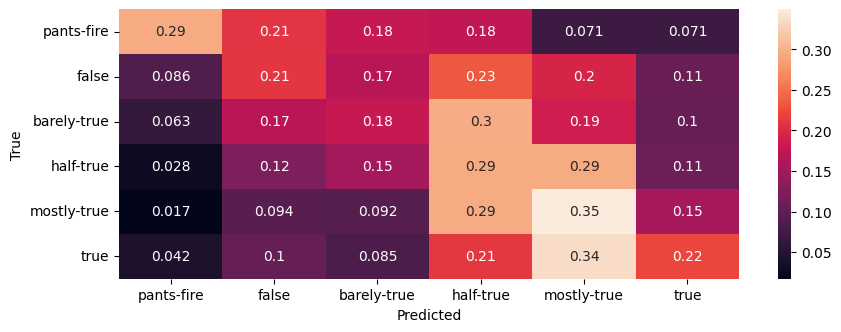

Class(es) with lowest f1 score: barely-true
Example concatenated statements that are getting misclassified:
Example: truthfulness: Says children are coming into the U.S. in staggering numbers because President Barack Obama has been promising amnesty. immigration ted-cruz Senator Texas<unk> /s.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [54]:
# Creating the T5 encoder only model to see if emolex/LIWC adds anything on top of this
evaluate_model(t5_extreme_model, t5_extreme_model_history, [test_extreme], train_labels, test_labels, test_input_ids, train_input_ids)

In [55]:

# Create a list to input into the model - positive emotions only
pos_cols = ['trust', 'positive', 'joy', 'emo_pos']

test_pos = np.array([[x[col] for col in pos_cols] for x in test])
train_pos = np.array([[x[col] for col in pos_cols] for x in train])
val_pos = np.array([[x[col] for col in pos_cols] for x in val])

In [57]:
t5_pos_model = create_t5_col_subset(input_size=len(pos_cols))

In [58]:
# Fit the model- six way
t5_pos_model_history = t5_pos_model.fit([train_input_ids, train_attention_mask, train_pos], 
    train_labels,   
    validation_data=(
        [val_input_ids, val_attention_mask, val_pos],  
        val_labels
    ),    
    batch_size=24, 
    epochs=10)

Epoch 1/10
321/321 [==============================] - 41s 110ms/step - loss: 0.9747 - accuracy: 0.6848 - val_loss: 2.5374 - val_accuracy: 0.2583
Epoch 2/10
321/321 [==============================] - 34s 106ms/step - loss: 0.5343 - accuracy: 0.8144 - val_loss: 3.1920 - val_accuracy: 0.2517
Epoch 3/10
321/321 [==============================] - 34s 106ms/step - loss: 0.4536 - accuracy: 0.8381 - val_loss: 3.5694 - val_accuracy: 0.2474
Epoch 4/10
321/321 [==============================] - 34s 106ms/step - loss: 0.4091 - accuracy: 0.8518 - val_loss: 3.8049 - val_accuracy: 0.2450
Epoch 5/10
321/321 [==============================] - 34s 106ms/step - loss: 0.3809 - accuracy: 0.8592 - val_loss: 4.0011 - val_accuracy: 0.2493
Epoch 6/10
321/321 [==============================] - 34s 106ms/step - loss: 0.3555 - accuracy: 0.8713 - val_loss: 4.1824 - val_accuracy: 0.2528
Epoch 7/10
321/321 [==============================] - 34s 106ms/step - loss: 0.3426 - accuracy: 0.8727 - val_loss: 4.1982 - val_ac

Learning Curve


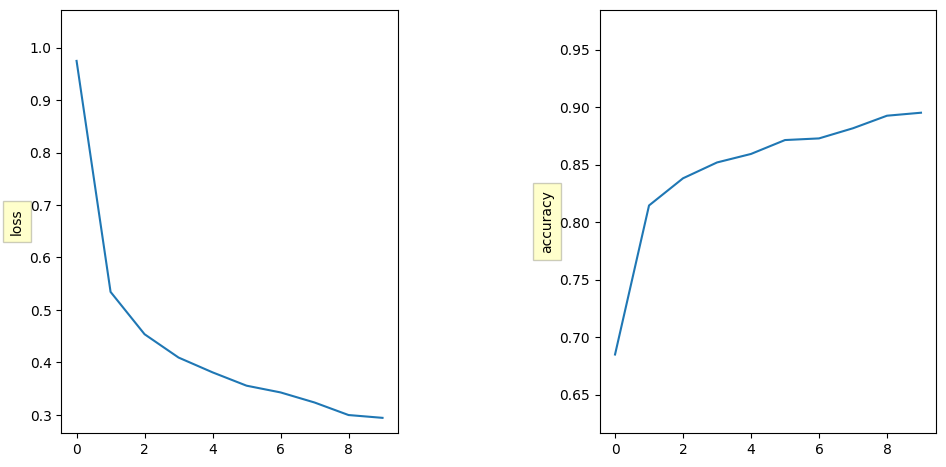

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.35      0.27      0.30       211
       false       0.28      0.24      0.26       523
 barely-true       0.22      0.18      0.20       429
   half-true       0.25      0.33      0.29       534
 mostly-true       0.28      0.32      0.30       469
        true       0.29      0.26      0.27       402

    accuracy                           0.27      2568
   macro avg       0.28      0.27      0.27      2568
weighted avg       0.27      0.27      0.27      2568

Confusion matrix


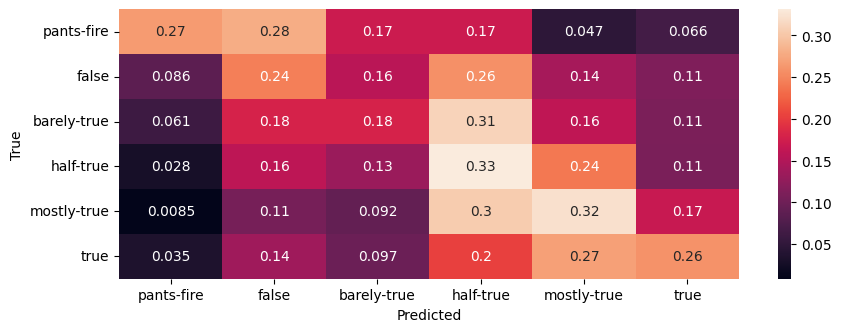

Class(es) with lowest f1 score: barely-true
Example concatenated statements that are getting misclassified:
Example: truthfulness: After Arizona banned smoking in all public places in 2007, admissions for acute myocardial infarction stroke, asthma, [and] angina decreased following the implementation of the ban. public-health market-regulation states richard-morrison State representative Rhode Island<unk> /s.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [59]:
# Creating the T5 encoder only model to see if emolex/LIWC adds anything on top of this
evaluate_model(t5_pos_model, t5_pos_model_history, [test_pos], train_labels, test_labels, test_input_ids, train_input_ids)

In [60]:

# Create a list to input into the model - negative emotions_only
neg_cols = ['fear', 'anger', 'anticipation', 'negative', 'sadness', 'disgust', 'emo_neg', 'emo_anx', 'emo_anger', 'emo_sad']

test_neg = np.array([[x[col] for col in neg_cols] for x in test])
train_neg = np.array([[x[col] for col in neg_cols] for x in train])
val_neg = np.array([[x[col] for col in neg_cols] for x in val])

In [62]:
t5_neg_model = create_t5_col_subset(input_size=len(neg_cols))

In [63]:
# Fit the model- six way
t5_neg_model_history = t5_neg_model.fit([train_input_ids, train_attention_mask, train_neg], 
    train_labels,   
    validation_data=(
        [val_input_ids, val_attention_mask, val_neg],  
        val_labels
    ),    
    batch_size=24, 
    epochs=10)

Epoch 1/10
321/321 [==============================] - 41s 110ms/step - loss: 0.8050 - accuracy: 0.7778 - val_loss: 2.8394 - val_accuracy: 0.2509
Epoch 2/10
321/321 [==============================] - 34s 106ms/step - loss: 0.3683 - accuracy: 0.8821 - val_loss: 3.6074 - val_accuracy: 0.2497
Epoch 3/10
321/321 [==============================] - 34s 106ms/step - loss: 0.2868 - accuracy: 0.9017 - val_loss: 4.0116 - val_accuracy: 0.2524
Epoch 4/10
321/321 [==============================] - 34s 106ms/step - loss: 0.2733 - accuracy: 0.9074 - val_loss: 4.2507 - val_accuracy: 0.2544
Epoch 5/10
321/321 [==============================] - 34s 106ms/step - loss: 0.2444 - accuracy: 0.9169 - val_loss: 4.4664 - val_accuracy: 0.2556
Epoch 6/10
321/321 [==============================] - 34s 106ms/step - loss: 0.2449 - accuracy: 0.9122 - val_loss: 4.5889 - val_accuracy: 0.2466
Epoch 7/10
321/321 [==============================] - 34s 106ms/step - loss: 0.2222 - accuracy: 0.9207 - val_loss: 4.6455 - val_ac

Learning Curve


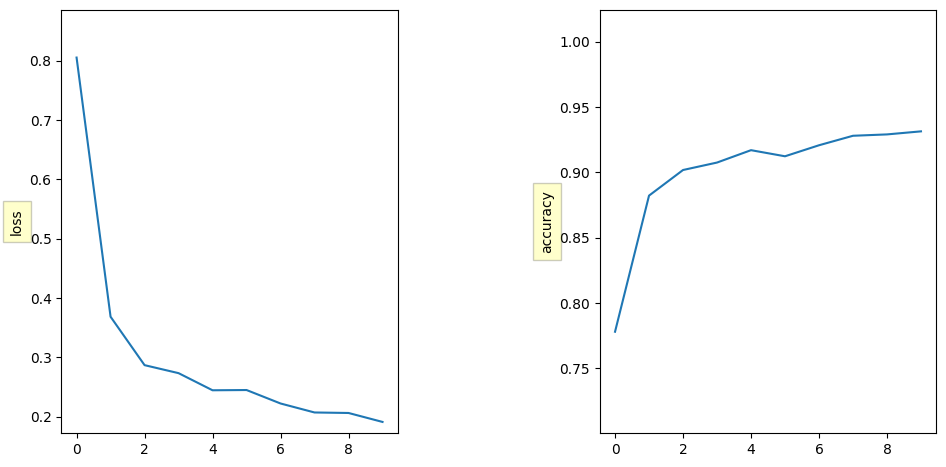

Precision, Recall, F1 Scores by class
              precision    recall  f1-score   support

  pants-fire       0.37      0.27      0.31       211
       false       0.28      0.27      0.27       523
 barely-true       0.23      0.17      0.20       429
   half-true       0.26      0.36      0.30       534
 mostly-true       0.27      0.31      0.29       469
        true       0.26      0.19      0.22       402

    accuracy                           0.27      2568
   macro avg       0.28      0.26      0.27      2568
weighted avg       0.27      0.27      0.26      2568

Confusion matrix


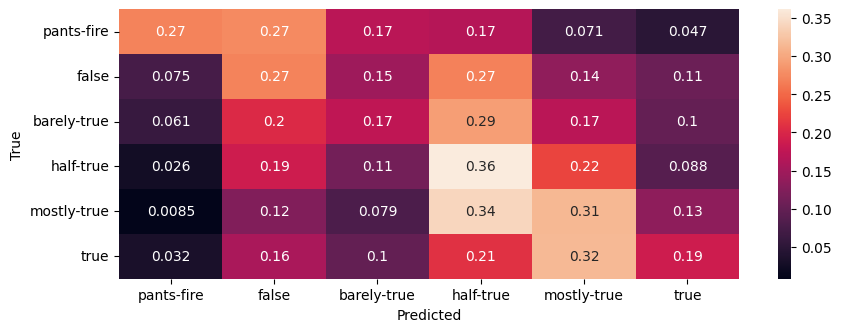

Class(es) with lowest f1 score: barely-true
Example concatenated statements that are getting misclassified:
Example: truthfulness: The federal government may put 16,500 IRS agents in charge of policing President Obamas health care bill. federal-budget government-efficiency health-care taxes michele-bachmann Congresswoman Minnesota<unk> /s.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [64]:
# Creating the T5 encoder only model to see if emolex/LIWC adds anything on top of this
evaluate_model(t5_neg_model, t5_neg_model_history, [test_neg], train_labels, test_labels, test_input_ids, train_input_ids)